# DSG 2020: Regression methods (practice)
## Teacher:
### Pierre Tandeo, IMT-Atlantique (pierre.tandeo@imt-atlantique.fr)
## Students:
### Santiago AGUDELO, IMT-Atlantique (santiago.agudelo-ramirez@imt-atlantique.net)
### Gonzalo QUINTANA, IMT-Atlantique (gonzalo-inaki.quintana@imt-atlantique.net)
### Gustavo RODRIGUES, IMT-Atlantique (gustavo.rodrigues-dos-reis@imt-atlantique.net)
In this notebook, we apply different regression methods to a real geophysical problem: the Lorenz-63 system. This system is said to be chaotic, meaning that its evolution is highly depending on the initial condition. Consequently, the evolution of this system is hard to predict.

![L63](https://upload.wikimedia.org/wikipedia/commons/1/13/A_Trajectory_Through_Phase_Space_in_a_Lorenz_Attractor.gif "Lorenz-63")

Here, based on a set of observations, the goal is firstly to identify the Lorenz-63 system, meaning that we want to retrieve the equations of the system using learning tools. The second objective is, from the identified data-driven models, to generate artificial trajectories of the Lorenz-63 system.

This practice is largely inspired by this article: https://www.pnas.org/content/pnas/113/15/3932.full.pdf.

# Preprocessing


## Import library and adjust python parameters

In [19]:
# import classical libraries
%matplotlib inline
%pylab inline

# library lyapunov exponent
!pip3 install nolds
import nolds
import math
import pickle
import numpy as np
import random
import pandas as pd
# avoid warnings
import warnings
warnings.filterwarnings("ignore")

# figure size
rcParams['figure.figsize'] = (16, 9)

# print only 2 decimals
set_printoptions(precision=2)

Populating the interactive namespace from numpy and matplotlib


In [4]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/Colab Notebooks/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Data generation

We generate data following the 3-dimensional Lorenz-63 system, also called the strange attractor, given by:

${\displaystyle {\begin{aligned}{\frac {\mathrm {d} x}{\mathrm {d} t}}&=\sigma (y-x),\\[6pt]{\frac {\mathrm {d} y}{\mathrm {d} t}}&=x(\rho -z)-y,\\[6pt]{\frac {\mathrm {d} z}{\mathrm {d} t}}&=x y-\beta z,\end{aligned}}}$

where the physical parameters are $\left(\sigma=10, \rho=28, \beta=8/3\right)$. We use Runge-Kutta 4-5 to integrate the model, using the *odeint()* Python function. The integration time is $\mathrm{d}t=0.001$ and we generate a sequence of $T=100$ Lorenz times.

In [0]:
# Lorenz-63 dynamical model
def Lorenz_63(x, dx, sigma, rho, beta):
    dx = zeros((3))
    dx[0] = sigma*(x[1]-x[0])
    dx[1] = x[0]*(rho-x[2])-x[1]
    dx[2] = x[0]*x[1] - beta*x[2]
    return dx

In [0]:
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

# define the parameters
x0 = array([8,0,30]) # initial condition
dt = 0.001 # integration time step
T = 30 # number of Lorenz-63 times
sigma = 10
rho = 28
beta = 8/3

# generate the Lorenz-63 system
x = odeint(Lorenz_63, x0, arange(0.01,T,dt), args=(sigma, rho, beta))
time = arange(0.01, T, dt)

## Visualize data

They are 2 ways of visualizing the Lorenz-63 system. The first is to consider the system as a 3-dimensional time series: we plot each variable as a function of time. The second is the phase-space representation where we plot the relationships between variables in 3D and we track the trajectory along time.

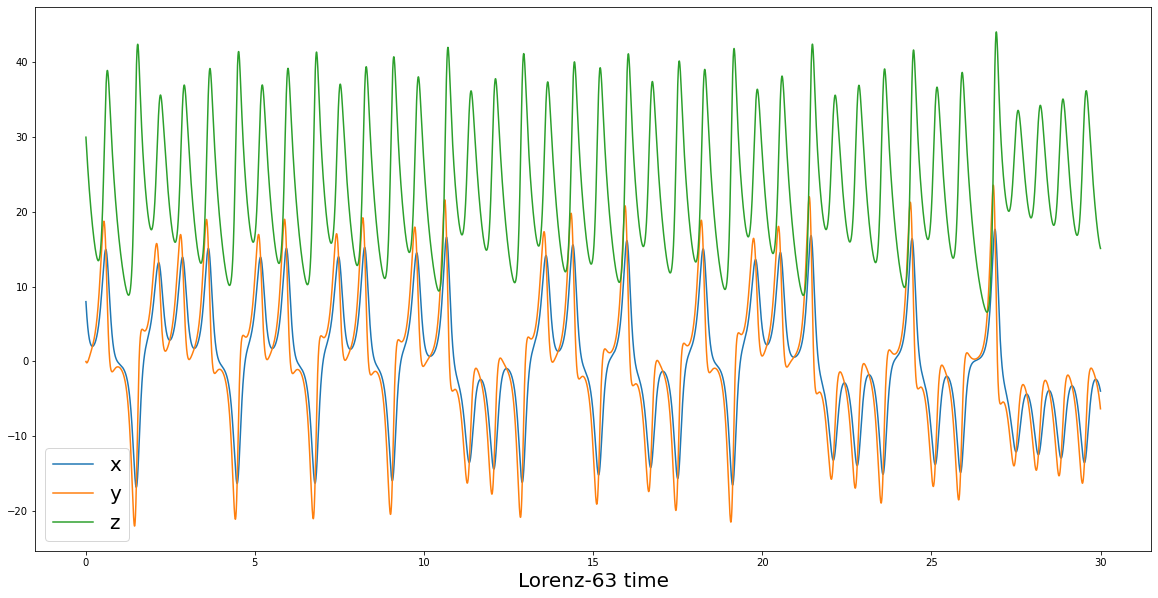

In [42]:
# time series representation
figure(figsize=(20,10))
plot(time, x)
xlabel('Lorenz-63 time', size=20)
legend(['x','y','z'], prop={'size': 20})

Text(0.5, 0, 'z')

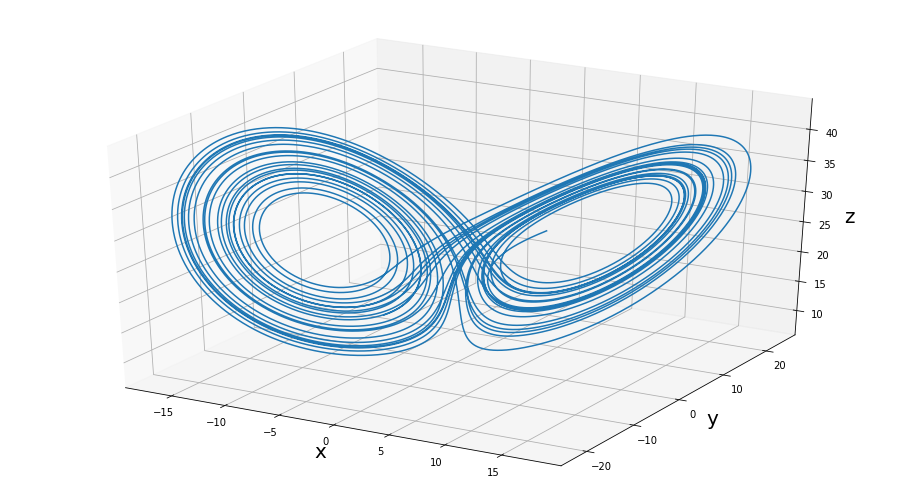

In [43]:
# phase-space representation
from mpl_toolkits.mplot3d import Axes3D
fig = figure()
ax = fig.gca(projection='3d')
ax.plot(x[:,0], x[:,1], x[:,2])
ax.set_xlabel('x', size=20);ax.set_ylabel('y', size=20);ax.set_zlabel('z', size=20)

## Create the training and validation datasets

Here, we want to statistically emulate the Lorenz-63 system, using a regression formulation such that $Y=f(X)$. The Lorenz-63 system is an Ordinary Differential Equation (ODE), where from an initial information at time $t$, the ODE results correspond to increments of each component of the system between $t$ and $t+\mathrm{d}t$.

**Questions:**
- construct the output $Y$ corresponding to the ODE formulation of the Lorenz-63
- construct the input $X$ with the information of the Lorenz-63 at time $t$ (we suggest to take the 3 dimensions and their products)
- create the training dataset noted (*X_train*, *Y_train*) corresponding to the first 2/3 of time series
- create the validation dataset noted (*X_test*, *Y_test*) corresponding to the last part of the time series

In [0]:
from numpy.random import normal

# output Y
Y = (x[1:,]-x[:-1,:])/dt

# input X    
X = vstack((x[:-1,0], x[:-1,1], x[:-1,2],\
            x[:-1,0]*x[:-1,0], x[:-1,0]*x[:-1,1], x[:-1,0]*x[:-1,2],\
            x[:-1,1]*x[:-1,1], x[:-1,1]*x[:-1,2], x[:-1,2]*x[:-1,2]\
           )).transpose()

# training set
T_train = int(T/dt*2/3) # size of the training set
X_train = X[0:T_train,:]
Y_train = Y[0:T_train,:]

# add noise to training data
#X_train = X_train + random.normal(0, 0.5, shape(X_train))
#Y_train = Y_train + random.normal(0, 0.5, shape(Y_train))

# validation set
X_test = X[T_train+1:,:]
Y_test = Y[T_train+1:,:]

### Apply the multiple linear regression

The regression $Y=f(X)$ can be simply written as a global linear regression without intercept such that: 
\begin{equation}
Y=\sum_{i=1}^p \beta_i X_i.
\end{equation}

**Questions:**
- estimate the $(\beta_1, \dots, \beta_p)$ using the ordinary least squares
- compare the estimated parameters to the true ones
- from the initial values in *X_test*, generate the predicted trajectories using the linear regressions and compare them to the true ones of *Y_test*

# Models

In [45]:
# import functions
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# adjust multiple linear regression (mlr) between X and Y
reg_mlr = Lasso(alpha=0.05)
reg_mlr2 = Ridge(alpha=0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, tol=0.001, solver='auto', random_state=None)
reg_mlr3 = Ridge(alpha=0.05)
reg_mlr4 = Ridge(alpha=0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, tol=0.001, solver='auto', random_state=None)

reg_mlr.fit(X_train, Y_train)
reg_mlr3.fit(X_train, Y_train)

# print the estimated parameters
#p = [around(reg_mlr.coef_[0,:], 1), around(reg_mlr.coef_[1,:], 1), around(reg_mlr.coef_[2,:], 1)]
np.set_printoptions(precision=4)
print('Estimated parameters for x Lasso: ' + str(around(reg_mlr.coef_[0,:], 2)))
print('Estimated parameters for y Lasso: ' + str(around(reg_mlr.coef_[1,:], 1)))
print('Estimated parameters for z Lasso: ' + str(around(reg_mlr.coef_[2,:], 2)))
print('Estimated parameters for x Ridge: ' + str(around(reg_mlr3.coef_[0,:], 2)))
print('Estimated parameters for y Ridge: ' + str(around(reg_mlr3.coef_[1,:], 1)))
print('Estimated parameters for z Ridge: ' + str(around(reg_mlr3.coef_[2,:], 2)))

Estimated parameters for x Lasso: [-9.15  9.54 -0.   -0.    0.   -0.02  0.    0.01 -0.  ]
Estimated parameters for y Lasso: [27.  -0.3  0.   0.  -0.  -1.   0.  -0.   0. ]
Estimated parameters for z Lasso: [-0.03 -0.01 -1.81  0.09  0.91  0.    0.02  0.   -0.02]
Estimated parameters for x Ridge: [-9.81  9.95  0.    0.   -0.   -0.    0.   -0.   -0.  ]
Estimated parameters for y Ridge: [27.7 -0.8  0.   0.  -0.  -1.   0.  -0.  -0. ]
Estimated parameters for z Ridge: [ 0.01 -0.01 -2.6   0.    0.98 -0.    0.01  0.   -0.  ]


## Galerkin regression


In [0]:
C = np.zeros((2,27))
C[:,0] =([0,1])
C[:,1] =([1,1])
d = np.array([10,0])


In [0]:
T = np.concatenate((np.concatenate((X,np.zeros((X.shape[0],X.shape[1])),np.zeros((X.shape[0],X.shape[1])))),np.concatenate((np.zeros((X.shape[0],X.shape[1])),X,np.zeros((X.shape[0],X.shape[1])))),np.concatenate((np.zeros((X.shape[0],X.shape[1])),np.zeros((X.shape[0],X.shape[1])),X))),axis=1)
Aa = np.concatenate((np.concatenate(((2*T).transpose().dot(T),C.transpose()),axis=1),np.concatenate((C,np.zeros((2,2))),axis=1)))
Ba = np.concatenate(((2*T).transpose().dot(Y.transpose().reshape(-1)),d))

In [48]:
j =  np.linalg.inv(Aa).dot(Ba)[:27].reshape(3,9)
j

array([[-1.0000e+01,  1.0000e+01, -5.1435e-04,  3.0644e-04, -9.5334e-04,
        -2.2824e-04,  5.3891e-04, -5.2804e-04,  5.8634e-06],
       [ 2.7797e+01, -8.0035e-01,  8.8821e-04,  8.8960e-04, -7.7941e-04,
        -9.9157e-01,  1.0339e-04, -1.0022e-02, -9.0219e-05],
       [-1.3052e-02,  8.0609e-03, -2.6535e+00, -3.6829e-03,  9.8717e-01,
         3.1133e-04,  1.1259e-02, -2.2912e-04, -3.2238e-04]])

In [0]:
reg_mlr2.coef_ = j
reg_mlr2.coef_
reg_mlr2.intercept_ = np.zeros((3))

In [50]:
np.set_printoptions(precision=4)
print('Estimated parameters for x Galerkin: ' + str(around(reg_mlr2.coef_[0,:], 2)))
print('Estimated parameters for y Galerkin: ' + str(around(reg_mlr2.coef_[1,:], 1)))
print('Estimated parameters for z Galerkin: ' + str(around(reg_mlr2.coef_[2,:], 2)))

Estimated parameters for x Galerkin: [-10.  10.  -0.   0.  -0.  -0.   0.  -0.   0.]
Estimated parameters for y Galerkin: [27.8 -0.8  0.   0.  -0.  -1.   0.  -0.  -0. ]
Estimated parameters for z Galerkin: [-0.01  0.01 -2.65 -0.    0.99  0.    0.01 -0.   -0.  ]


## Jaya-Powell algorithm

In [0]:
A = np.zeros((9,3))
b = np.zeros((3))

In [0]:
def myobj(p1,k):
    F=[]
    for i in range (len(p1)):
        x=p1.loc[i]
        f = np.linalg.norm(X_train.dot(x)-Y_train[:,k])**2 + np.linalg.norm(x,ord=1)
        F.append(f)
    return F

def sparte(x):
    f = np.linalg.norm(X_train.dot(x)-Y_train[:,k],ord=2)**2 + np.linalg.norm(x,ord=1)
    return f

def initialpopulation(mini,maxi,pop_size):
    pop=[]        
    for i in range(pop_size):
        p=[]        
        for a,b in zip(mini,maxi):
            p.append(a + (b-a) * random.random())
        pop.append(p)    
    ini_pop=pd.DataFrame(pop)        
    return ini_pop

def updatepopulation(p1,dim):      
  best_x=np.array(p1.loc[p1['f'].idxmin][0:dim])    
  worst_x=np.array(p1.loc[p1['f'].idxmax][0:dim])
  new_x=[]
  for i in range(len(p1)):
      old_x=np.array(p1.loc[i][0:dim])           
      r1=np.random.random(dim)
      r2=np.random.random(dim)
      new_x.append(old_x+r1*(best_x-abs(old_x))-r2*(worst_x-abs(old_x)))    
  new_p1=pd.DataFrame(new_x)    
  return new_p1

def greedyselector(p1,new_p1):    
    for i in range(len(p1)):        
        if p1.loc[i]['f']>new_p1.loc[i]['f']:                 
            p1.loc[i]=new_p1.loc[i]    
    return p1

def trimr(new_p1,lb,ub):    
    col=new_p1.columns.values    
    for i in range(len(new_p1)):        
        for j in range(len(col)):            
            if new_p1.loc[i][j]>ub[j]:                
                  new_p1.loc[i][j]=ub[j]            
            elif new_p1.loc[i][j]<lb[j]:                          
                  new_p1.loc[i][j]=lb[j]    
    return new_p1

def jaya(*argv):
    pop_size, Gen, mini, maxi, k= argv
    lb=np.array(mini)
    ub=np.array(maxi)
    p1=initialpopulation(lb,ub,pop_size)
    p1['f']=myobj(p1,k)
    
    dim=len(lb)
    gen=0
    best=[]
    while (gen<Gen):
        new_p1=updatepopulation(p1,dim)
        new_p1=trimr(new_p1,lb,ub)
        new_p1['f']=myobj(new_p1, k)
        p1=greedyselector(p1,new_p1)
        gen=gen+1
    #     print(gen)
        best=p1['f'].min()
        xbest=p1.loc[p1['f'].idxmin()][0:dim].tolist()
#     print('Best={}'.format(best))
#     print('xbest={}'.format(xbest))
    return best,xbest

In [83]:
pop_size = 10
Gen = 100
lb=[-20,-10,-10,-1,-1,-1,-1,-1,-1]
ub=[30,10,10,1,1,1,1,1,1]
for k in range(0,3):
  print(k)
  best,xbest = jaya(pop_size, Gen, lb, ub,k)
  print('The objective function value = {}'.format(best))
  print('The optimum values of variables = {}'.format(xbest))

  from scipy.optimize import minimize
  xbest = np.array([20.0,  9.9458e+00,  7.3055e-06, -4.3154e-06,  4.2596e-06,
        -4.9590e-03, -1.8972e-07, -3.0814e-05,  2.7884e-07])
  res = minimize(sparte, xbest, method='Powell',options={ 'xtol': 0.0001, 'ftol': 0.0001, 'maxiter': None, 'disp': True})
  A[:,k] = res.x

0
The objective function value = 45729.91380360746
The optimum values of variables = [15.086923890140294, -3.673052637862947, 0.44591874608024523, 0.3267513469088538, -0.39156564474568567, -0.6474623525242408, 0.20705049306737883, 0.26667638182625825, -0.03141344213015747]
Optimization terminated successfully.
         Current function value: 5073.483197
         Iterations: 16
         Function evaluations: 1385
1
The objective function value = 335861.3601018085
The optimum values of variables = [7.533900708323193, -3.6638096212176, -2.794281731283447, -1.0, 0.40482258017234174, -0.4537987831401671, 0.1871131966155024, 0.16867372556232782, 0.146303073554159]
Optimization terminated successfully.
         Current function value: 77324.731901
         Iterations: 17
         Function evaluations: 1484
2
The objective function value = 216846.67148516397
The optimum values of variables = [0.6401630810071275, 7.776851976458547, -1.3734267322020564, -1.0, 0.9746467851119373, 0.0673374834029

In [0]:
reg_mlr4.coef_ = A.transpose()
reg_mlr4.coef_
reg_mlr4.intercept_ = np.zeros((3))

In [0]:

# save the model to disk
filename = 'JP01.sav'
pickle.dump(reg_mlr4, open(path+filename, 'wb'))

In [0]:
# load the model from disk
filename = 'JP.sav'
reg_mlr4 = pickle.load(open(path+filename, 'rb'))

In [52]:
np.set_printoptions(precision=4)
print('Estimated parameters for x Jaya-Powell: ' + str(around(reg_mlr4.coef_[0,:], 2)))
print('Estimated parameters for y Jaya-Powell: ' + str(around(reg_mlr4.coef_[1,:], 1)))
print('Estimated parameters for z Jaya-Powell: ' + str(around(reg_mlr4.coef_[2,:], 2)))

Estimated parameters for x Jaya-Powell: [-9.81  9.95  0.   -0.    0.   -0.   -0.   -0.    0.  ]
Estimated parameters for y Jaya-Powell: [27.6 -0.7  0.  -0.   0.  -1.   0.  -0.  -0. ]
Estimated parameters for z Jaya-Powell: [ 0.06 -0.03 -2.66 -0.    0.98 -0.    0.01  0.   -0.  ]


# Results

In [0]:
# function to transform the input and output of the regression to a L63 coordinate
def XY_to_L63(X, Y, dt):
    
    L63 = Y*dt + X
    
    # return the L63 coordinate
    return L63

# function to transform a L3 coordinate to the input of the regression, assuming that:
# X = [x1, x2, x3, x1x1, x1x2, x1x3, x2x2, x2x3, x3x3]
def L63_to_X(trajectory):
    
    X = vstack((trajectory[0], trajectory[1], trajectory[2],\
        trajectory[0]*trajectory[0], trajectory[0]*trajectory[1], trajectory[0]*trajectory[2],\
        trajectory[1]*trajectory[1], trajectory[1]*trajectory[2], trajectory[2]*trajectory[2]\
        )).transpose()
    
    # return the X vector
    return X



In [0]:
# apply the linear regressions (only the firt time step is kept into account)
Y_mlr = reg_mlr.predict(X_test)
Y_mlr2 = reg_mlr2.predict(X_test)
Y_mlr3 = reg_mlr3.predict(X_test)
Y_mlr4 = reg_mlr4.predict(X_test)
# apply sequentially the linear regressions from the initial value of X_test
traj_true = Y_test*0
traj_mlr = Y_test*0
traj_mlr2 = Y_test*0
traj_mlr3 = Y_test*0
traj_mlr4 = Y_test*0

traj_true[0,:] = XY_to_L63(X_test[0,0:3], Y_test[0,:], dt)
traj_mlr[0,:] = XY_to_L63(X_test[0,0:3], Y_mlr[0,:], dt)
traj_mlr2[0,:] = XY_to_L63(X_test[0,0:3], Y_mlr2[0,:], dt)
traj_mlr3[0,:] = XY_to_L63(X_test[0,0:3], Y_mlr3[0,:], dt)
traj_mlr4[0,:] = XY_to_L63(X_test[0,0:3], Y_mlr4[0,:], dt)

for t in range(1,len(X_test)):
    traj_true[t,:] = XY_to_L63(X_test[t,0:3], Y_test[t,:], dt)
    # apply the linear regressions recursively
    traj_mlr[t,:] = XY_to_L63(traj_mlr[t-1,:], reg_mlr.predict(L63_to_X(traj_mlr[t-1,:])), dt)
    traj_mlr2[t,:] = XY_to_L63(traj_mlr2[t-1,:], reg_mlr2.predict(L63_to_X(traj_mlr2[t-1,:])), dt)
    traj_mlr3[t,:] = XY_to_L63(traj_mlr3[t-1,:], reg_mlr3.predict(L63_to_X(traj_mlr3[t-1,:])), dt)
    traj_mlr4[t,:] = XY_to_L63(traj_mlr4[t-1,:], reg_mlr4.predict(L63_to_X(traj_mlr4[t-1,:])), dt)

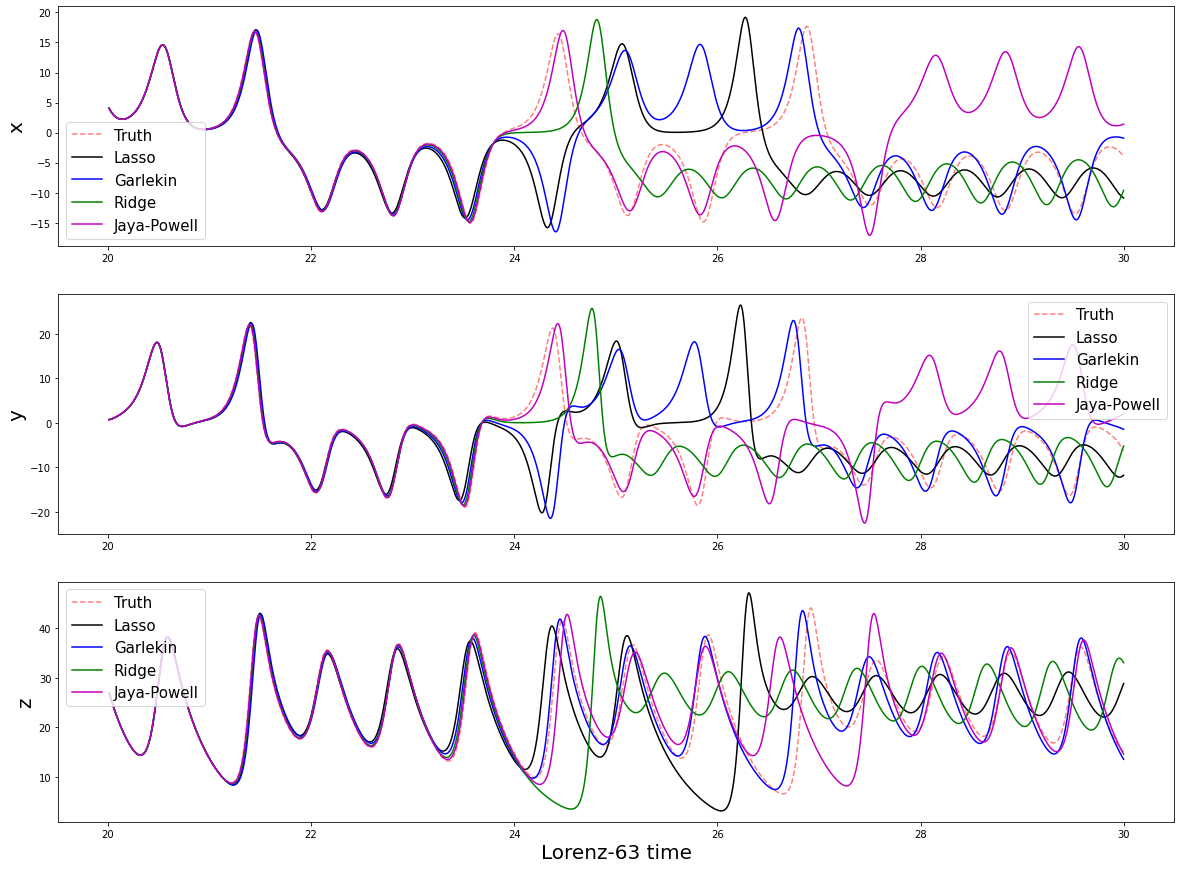

In [55]:
# time series representation
plt.figure(figsize=(20,15))
plt.subplot(311)
plt.plot(time[T_train+2:], traj_true[:,0], '--r',alpha=0.5)
plt.plot(time[T_train+2:], traj_mlr[:,0], 'k')
plt.plot(time[T_train+2:], traj_mlr2[:,0], 'b')
plt.plot(time[T_train+2:], traj_mlr3[:,0], 'g')
plt.plot(time[T_train+2:], traj_mlr4[:,0], 'm')

plt.ylabel('x', size=20)
plt.legend(['Truth','Lasso', 'Garlekin', 'Ridge', 'Jaya-Powell'], prop={'size': 15})
plt.subplot(312)
plt.plot(time[T_train+2:], traj_true[:,1], '--r',alpha=0.5)
plt.plot(time[T_train+2:], traj_mlr[:,1], 'k')
plt.plot(time[T_train+2:], traj_mlr2[:,1], 'b')
plt.plot(time[T_train+2:], traj_mlr3[:,1], 'g')
plt.plot(time[T_train+2:], traj_mlr4[:,1], 'm')

plt.ylabel('y', size=20)
plt.legend(['Truth','Lasso', 'Garlekin','Ridge','Jaya-Powell' ], prop={'size': 15})
plt.subplot(313)
plt.plot(time[T_train+2:], traj_true[:,2], '--r',alpha=0.5)
plt.plot(time[T_train+2:], traj_mlr[:,2], 'k')
plt.plot(time[T_train+2:], traj_mlr2[:,2], 'b')
plt.plot(time[T_train+2:], traj_mlr3[:,2], 'g')
plt.plot(time[T_train+2:], traj_mlr4[:,2], 'm')
plt.xlabel('Lorenz-63 time', size=20)
plt.ylabel('z', size=20)
plt.legend(['Truth','Lasso', 'Garlekin', 'Ridge','Jaya-Powell'], prop={'size': 15})


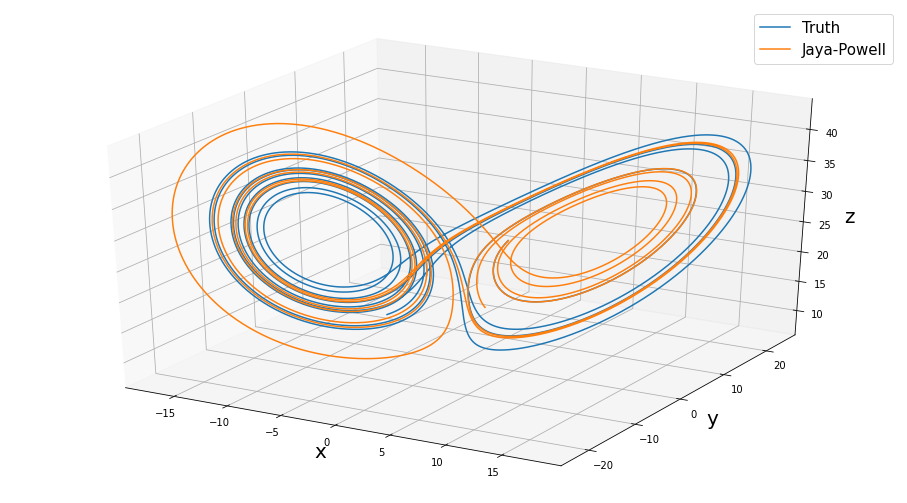

In [56]:
fig = figure()
ax = fig.gca(projection='3d')
ax.plot(traj_true[:,0], traj_true[:,1], traj_true[:,2])
ax.plot(traj_mlr4[:,0], traj_mlr4[:,1], traj_mlr4[:,2])
ax.set_xlabel('x', size=20);ax.set_ylabel('y', size=20);ax.set_zlabel('z', size=20)
plt.legend(['Truth', 'Jaya-Powell'], prop={'size': 15})

# Lyapunov exponent




### Lyapunov exponent function

In [0]:
import numpy as np
from sklearn.linear_model import LinearRegression

def Lyap_exp(serie1, serie2, dt, T):
  ts = 25 #time change in Lorenz 63
  time = arange(0, ts, dt)
  s1 = serie1[:int(ts/dt)]
  s2 = serie2[:int(ts/dt)]
  delta = np.sqrt(np.sum((s1-s2)**2,axis=1))
  for j in range(len(delta)):
    if delta[j] == 0:
      delta[j] = 1e-20
  reg = LinearRegression().fit(time.reshape(-1, 1), np.log(delta).reshape(-1, 1))
  le = reg.coef_[0][0]
  return le

### Computation of time series Model de Lorenz 63

In [0]:
# Lorenz-63 dynamical model
def Lorenz_63(x, dx, sigma, rho, beta):
    dx = zeros((3))
    dx[0] = sigma*(x[1]-x[0])
    dx[1] = x[0]*(rho-x[2])-x[1]
    dx[2] = x[0]*x[1] - beta*x[2]
    return dx

In [0]:
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

# define the parameters
x0 = array([8,0,30]) # initial condition
dt = 0.001 # integration time step
T = 30 # number of Lorenz-63 times
A = reg_mlr.coef_
b = reg_mlr.intercept_
sigma = 10
rho = 28
beta = 8/3

# generate the Lorenz-63 system
x = odeint(Lorenz_63, x0, arange(0,T,dt), args=(sigma, rho, beta))
time = arange(0, T, dt)

In [70]:
## Statistical analysis
from tqdm import tqdm
nt = 10
lambdae = np.zeros((nt))

#for i in range(0,nt):
for i in tqdm(range(nt)):
  epsilon = 1e-10*np.random.randn(3)
  xn = odeint(Lorenz_63, x0 + epsilon, arange(0,T,dt), args=(sigma, rho, beta))
  lambdae[i] = Lyap_exp(x, xn, dt, T)

100%|██████████| 10/10 [00:00<00:00, 19.67it/s]


In [71]:
print("Lyapunov exponent for original Lorenz Model : "+"{:.4f}".format(np.mean(lambdae))+'--'+"{:.4f}".format(np.std(lambdae)))

Lyapunov exponent for original Lorenz Model : 0.9626--0.0060


### Lyapunov exponent with libra

In [43]:
from tqdm import tqdm
nt = 10
lambda_lb = np.zeros((nt,3))
for j in tqdm(range(nt)):
    lambda_lb[j,0] = nolds.lyap_r(x[:,0],tau=dt)
    lambda_lb[j,1] = nolds.lyap_r(x[:,1],tau=dt)
    lambda_lb[j,2] = nolds.lyap_r(x[:,2],tau=dt)

100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


In [44]:
print("Lyapunov exponent with librari for original Lorenz Model : "+"{:.4f}".format(np.mean(lambda_lb,axis=0)[0])+'--'+"{:.4f}".format(np.mean(lambda_lb,axis=0)[1])+'--'+"{:.4f}".format(np.mean(lambda_lb,axis=0)[2]))

Lyapunov exponent with librari for original Lorenz Model : 0.6872--0.8336--2.5536


### Dynamical model for the Sparse approximations

In [0]:
def model_lorenz63(x,dx,A,b):
  # input X    
  X = vstack((1,x[0], x[1], x[2],x[0]*x[0], x[0]*x[1], x[0]*x[2],x[1]*x[1], x[1]*x[2], x[2]*x[2])).transpose()
  dx = np.zeros((3))
  dx[0] = X.dot(np.insert(A[0,:],0,b[0]))
  dx[1] = X.dot(np.insert(A[1,:],0,b[1]))
  dx[2] = X.dot(np.insert(A[2,:],0,b[2]))
  return dx

### Computation of time series Model de Lorenz 63 - Lasso

In [0]:
# define the parameters
x0 = array([8,0,30]) # initial condition
dt = 0.001 # integration time step
T = 30 # number of Lorenz-63 times
A = reg_mlr.coef_
b = reg_mlr.intercept_

# generate the Lorenz-63 system
x = odeint(model_lorenz63, x0, arange(0.1,T,dt), args=(A,b))
time = arange(0.1, T, dt)

In [65]:
## Statistical analysis

nt = 10
lambdae = np.zeros((nt))

for i in tqdm(range(nt)):
  epsilon = 1e-10*np.random.randn(3)
  xn = odeint(model_lorenz63, x0 + epsilon, arange(0,T,dt), args=(A,b))
  lambdae[i] = Lyap_exp(x, xn, dt, T)
  print(lambdae)

 10%|█         | 1/10 [00:00<00:07,  1.20it/s]

[0.7284 0.     0.     0.     0.     0.     0.     0.     0.     0.    ]


 20%|██        | 2/10 [00:01<00:06,  1.20it/s]

[0.7284 0.7381 0.     0.     0.     0.     0.     0.     0.     0.    ]


 30%|███       | 3/10 [00:02<00:05,  1.21it/s]

[0.7284 0.7381 0.7408 0.     0.     0.     0.     0.     0.     0.    ]


 40%|████      | 4/10 [00:03<00:04,  1.21it/s]

[0.7284 0.7381 0.7408 0.7409 0.     0.     0.     0.     0.     0.    ]


 50%|█████     | 5/10 [00:04<00:04,  1.21it/s]

[0.7284 0.7381 0.7408 0.7409 0.731  0.     0.     0.     0.     0.    ]


 60%|██████    | 6/10 [00:04<00:03,  1.20it/s]

[0.7284 0.7381 0.7408 0.7409 0.731  0.7227 0.     0.     0.     0.    ]


 70%|███████   | 7/10 [00:05<00:02,  1.20it/s]

[0.7284 0.7381 0.7408 0.7409 0.731  0.7227 0.7413 0.     0.     0.    ]


 80%|████████  | 8/10 [00:06<00:01,  1.20it/s]

[0.7284 0.7381 0.7408 0.7409 0.731  0.7227 0.7413 0.7406 0.     0.    ]


 90%|█████████ | 9/10 [00:07<00:00,  1.20it/s]

[0.7284 0.7381 0.7408 0.7409 0.731  0.7227 0.7413 0.7406 0.7294 0.    ]


100%|██████████| 10/10 [00:08<00:00,  1.21it/s]

[0.7284 0.7381 0.7408 0.7409 0.731  0.7227 0.7413 0.7406 0.7294 0.7404]


In [66]:
print("Lyapunov exponent for Lasso Lorenz Model : "+"{:.4f}".format(np.mean(lambdae))+'--'+"{:.4f}".format(np.std(lambdae)))

Lyapunov exponent for Lasso Lorenz Model : 0.7354--0.0065


### Computation of time series Model de Lorenz 63 - Garlekin

In [0]:
# define the parameters
x0 = array([8,0,30]) # initial condition
dt = 0.001 # integration time step
T = 30 # number of Lorenz-63 times
A = reg_mlr2.coef_
b = reg_mlr2.intercept_

# generate the Lorenz-63 system
x = odeint(model_lorenz63, x0, arange(0,T,dt), args=(A,b))
time = arange(0, T, dt)

In [75]:
## Statistical analysis

nt = 10
lambdae = np.zeros((nt))

for i in tqdm(range(nt)):
  epsilon = 1e-10*np.random.randn(3)
  xn = odeint(model_lorenz63, x0 + epsilon, arange(0,T,dt), args=(A,b))
  lambdae[i] = Lyap_exp(x, xn, dt, T)

100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


In [76]:
print("Lyapunov exponent for Garlekin Lorenz Model : "+"{:.4f}".format(np.mean(lambdae))+'--'+"{:.4f}".format(np.std(lambdae)))

Lyapunov exponent for Garlekin Lorenz Model : 0.8829--0.1140


### Computation of time series Model de Lorenz 63 - Ridge

In [0]:
# define the parameters
x0 = array([8,0,30]) # initial condition
dt = 0.001 # integration time step
T = 30 # number of Lorenz-63 times
A = reg_mlr3.coef_
b = reg_mlr3.intercept_

# generate the Lorenz-63 system
x = odeint(model_lorenz63, x0, arange(0,T,dt), args=(A,b))
time = arange(0, T, dt)

In [83]:
## Statistical analysis

nt = 10
lambdae = np.zeros((nt))

for i in tqdm(range(nt)):
  epsilon = 1e-10*np.random.randn(3)
  xn = odeint(model_lorenz63, x0 + epsilon, arange(0,T,dt), args=(A,b))
  lambdae[i] = Lyap_exp(x, xn, dt, T)

100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


In [84]:
print("Lyapunov exponent for Ridge Lorenz Model : "+"{:.4f}".format(np.mean(lambdae))+'--'+"{:.4f}".format(np.std(lambdae)))

Lyapunov exponent for Ridge Lorenz Model : 0.8518--0.0532


### Computation of time series Model de Lorenz 63 - Jaya-Powell

In [0]:
# define the parameters
x0 = array([8,0,30]) # initial condition
dt = 0.001 # integration time step
T = 30 # number of Lorenz-63 times
A = reg_mlr4.coef_
b = reg_mlr4.intercept_

# generate the Lorenz-63 system
x = odeint(model_lorenz63, x0, arange(0,T,dt), args=(A,b))
time = arange(0, T, dt)

In [86]:
## Statistical analysis

nt = 30
lambdae = np.zeros((nt))

for i in tqdm(range(nt)):
  epsilon = 1e-10*np.random.randn(3)
  xn = odeint(model_lorenz63, x0 + epsilon, arange(0,T,dt), args=(A,b))
  lambdae[i] = Lyap_exp(x, xn, dt, T)

100%|██████████| 30/30 [00:23<00:00,  1.27it/s]


In [87]:
print("Lyapunov exponent for Ridge Lorenz Model : "+"{:.4f}".format(np.mean(lambdae))+'--'+"{:.4f}".format(np.std(lambdae)))

Lyapunov exponent for Ridge Lorenz Model : 0.8308--0.0849


# RMSE

In [0]:
from sklearn.metrics import mean_squared_error

sigma = 10
rho = 28
beta = 8/3

p = np.zeros((3,9))
p[0,0] = -sigma
p[0,1] = sigma
p[1,0] = rho
p[1,1] = -1
p[1,5] = -1
p[2,2] = -beta
p[2,4] = 1

#### Lasso

In [89]:
math.sqrt(mean_squared_error(p,reg_mlr.coef_))

0.3394640231442204

#### Galerkin

In [90]:
math.sqrt(mean_squared_error(p,reg_mlr2.coef_))

0.055041688052776164

#### Ridge

In [91]:
math.sqrt(mean_squared_error(p,reg_mlr3.coef_))

0.08334809390982721

#### Jaya-Powell

In [92]:
math.sqrt(mean_squared_error(p,reg_mlr4.coef_))

0.09893826340375912